<a href="https://colab.research.google.com/github/Willlee0225/nbviewer/blob/master/Stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 利用道瓊指數成分股，石油價格和相關指數來預測道瓊的漲跌



## 先將所需的套件獨進來
##我們這次是使用RNN裡面的LSTM，因為RNN可以解決時間序列的問題，一般的標準神經網路，在inpute資料通常是沒有時間性的資料。而RNN透過將Hidden layer的output存在Memory裡，當下次input資料進去時，會同時考慮上一次存在Memory的值進行計算。

In [0]:
#coding=utf-8
import pandas as pd
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.utils import to_categorical
%matplotlib inline

In [0]:
%tensorflow_version 2.x

In [141]:
from google.colab import files
uploaded = files.upload()

Saving data3.csv to data3 (2).csv


In [0]:
import io
df1 = pd.read_csv(io.BytesIO(uploaded['data3.csv']))

## 由於各項Features 的差距其實蠻大的，為了不要失真，我們將所有資料進行標準化，讓所有資料都介於0~1之間


In [0]:
def normalize(df):
    norm = df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    return norm

## 1. LSTM model 有許多種變化，One to One 、 One to many 、 Many to one 或者 Many to many，經過多次嘗試，我們決定使用Many to one，亦即利用前五天的資料來預測下一天的漲跌，因此Input就是前五天的股價，而輸出就是第六天的股價。將5天的資料視為一句話(一個序列的意思)
## 2. 用迴圈方式依序創建 X_train 跟 Y_train

In [0]:
def train_windows(df, ref_day=5, predict_day=1):
    X_train, Y_train = [], []
    for i in range(df.shape[0]-predict_day-ref_day):
        X_train.append(np.array(df.iloc[i:i+ref_day,:-1]))
        Y_train.append(np.array(df.iloc[i+ref_day:i+ref_day+predict_day]["y"]))
    return np.array(X_train), np.array(Y_train)

### 將DOW 的每一個值都往前移一天

In [0]:
df1['y'] = df1['DOW'].shift(-1)

### 進行標準化


In [0]:
df1.iloc[:,[1,2,3,4,5,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]]=normalize(df1.iloc[:,[1,2,3,4,5,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]])

### 整理資料

In [0]:
df1 = df1.dropna()

In [148]:
df1

,Date,MMM,KO,CVX,CAT,BA,AXP,AAPL,XOM,WMT,WBA,VZ,UNH,TRV,PG,NIKE,MSFT,MRK,JPM,JNJ,INTC,IBM,HD,DIS,MCD,SP,NASDAQ,DOW,BP,y
0,1987/5/20,0.028840,0.012630,0.052596,0.015463,0.018688,0.061161,0.038624,0.029384,0.010524,0.011279,0.007471,0.001533,0.019495,0.023713,0.000171,0.001815,0.002160,0.157860,0.016498,0.004135,0.185534,0.003513,0.028567,0.022746,0.040478,0.024113,0.038398,0.070671,0.039195
1,1987/5/21,0.027702,0.012259,0.052924,0.015772,0.018688,0.065379,0.023103,0.029204,0.012395,0.011279,0.004598,0.001533,0.020714,0.022169,0.000342,0.001933,0.003361,0.165886,0.016613,0.004135,0.186537,0.003634,0.030607,0.023845,0.041939,0.024513,0.039195,0.069336,0.040598
2,1987/5/22,0.028651,0.013930,0.052596,0.016082,0.019803,0.065906,0.012765,0.028483,0.012979,0.011279,0.011494,0.001533,0.020714,0.023492,0.000342,0.001742,0.004801,0.169231,0.016957,0.003609,0.185534,0.003674,0.030862,0.026456,0.043423,0.024281,0.040598,0.070078,0.045003
3,1987/5/26,0.032256,0.016716,0.054568,0.017782,0.020640,0.073815,0.020198,0.030105,0.014032,0.012062,0.017241,0.001594,0.026806,0.027353,0.000342,0.001815,0.004561,0.176589,0.018446,0.004345,0.191953,0.003875,0.035709,0.028655,0.048605,0.025122,0.045003,0.070671,0.044832
4,1987/5/27,0.032635,0.015973,0.054897,0.019020,0.024266,0.072233,0.024033,0.029564,0.014500,0.012376,0.022988,0.001533,0.028024,0.026470,0.000513,0.001815,0.005761,0.170569,0.018217,0.004345,0.192555,0.004517,0.036729,0.028518,0.048321,0.025375,0.044832,0.070449,0.046028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5994,2011/2/25,0.931998,0.719138,0.978015,0.961800,0.649266,0.639277,0.050898,0.887972,0.735267,0.809307,0.457412,0.666112,0.974266,0.832990,0.952716,0.443202,0.277753,0.695197,0.815512,0.286594,0.975802,0.536488,0.972200,0.922157,0.817131,0.523291,0.836302,0.788283,0.844019
5995,2011/2/28,0.956041,0.714502,0.995372,0.971004,0.646354,0.639932,0.054005,0.890164,0.738709,0.836778,0.476839,0.667054,0.980700,0.835955,0.964208,0.443708,0.282132,0.695358,0.841909,0.281346,0.973235,0.542196,0.991809,0.938517,0.822603,0.523548,0.844019,0.793771,0.830473
5996,2011/3/1,0.934548,0.726270,0.986430,0.940622,0.627376,0.633052,0.061157,0.881742,0.740056,0.824346,0.458434,0.665014,0.966858,0.831578,0.949651,0.436624,0.280864,0.677860,0.831057,0.280269,0.960976,0.531804,0.973193,0.928094,0.807028,0.514117,0.830473,0.810753,0.831179
5997,2011/3/2,0.944991,0.720565,0.992426,0.951607,0.621854,0.630922,0.080897,0.884973,0.738559,0.806700,0.464978,0.682438,0.958865,0.826919,0.956547,0.435275,0.282247,0.671599,0.832670,0.281615,0.962195,0.530341,0.980640,0.925455,0.808601,0.516358,0.831179,0.822024,0.846583


## 將測試資料讀進來

In [149]:
from google.colab import files
uploaded = files.upload()

Saving test3.csv to test3 (2).csv


In [0]:
import io
df2 = pd.read_csv(io.BytesIO(uploaded['test3.csv']))

In [0]:
df2['y'] = df2['DOW'].shift(-1)

In [0]:
df2.iloc[:,[1,2,3,4,5,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]]=normalize(df2.iloc[:,[1,2,3,4,5,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]])

In [0]:
df2 = df2.dropna()

In [0]:
df1.drop(['Date'], axis=1, inplace=True)

In [0]:
df2.drop(['Date'], axis=1, inplace=True)

In [156]:
df2

,MMM,KO,CVX,CAT,BA,AXP,AAPL,XOM,WMT,WBA,VZ,UNH,TRV,PG,NIKE,MSFT,MRK,JPM,JNJ,INTC,IBM,HD,DIS,MCD,SP,NASDAQ,DOW,BP,y
0,0.114385,0.061712,0.605110,0.391397,0.035150,0.014275,0.342770,0.730426,0.043017,0.189984,0.099827,0.006491,0.112561,0.046627,0.039286,0.012183,0.048530,0.149144,0.028002,0.040990,0.538379,0.038259,0.114318,0.022273,0.092220,0.054776,0.075927,0.929971,0.082508
1,0.121577,0.068871,0.614535,0.409099,0.038178,0.030454,0.212826,0.728781,0.048022,0.197961,0.116062,0.007515,0.113487,0.051581,0.040074,0.013334,0.050940,0.159879,0.031170,0.039367,0.557796,0.039037,0.115786,0.017211,0.097332,0.057468,0.082508,0.878910,0.082440
2,0.118487,0.068531,0.594320,0.393432,0.038308,0.028445,0.279226,0.725764,0.050763,0.201211,0.121934,0.010021,0.116634,0.050852,0.039374,0.013213,0.055922,0.161299,0.028002,0.040787,0.587375,0.041920,0.115134,0.018831,0.096545,0.055590,0.082440,0.879090,0.070348
3,0.101652,0.062905,0.556369,0.358293,0.036220,0.017553,0.316355,0.684629,0.050524,0.191609,0.113299,0.007364,0.108488,0.043421,0.037128,0.010304,0.049655,0.152160,0.019928,0.032468,0.555647,0.039174,0.109834,0.024906,0.085652,0.048813,0.070348,0.870550,0.073512
4,0.110176,0.054722,0.566911,0.372721,0.037134,0.020302,0.291395,0.694776,0.049809,0.191166,0.094300,0.006604,0.111821,0.043421,0.034182,0.011940,0.046923,0.154024,0.020746,0.034091,0.559035,0.039495,0.113584,0.025243,0.089662,0.050764,0.073512,0.856796,0.070801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2218,0.566489,0.837027,0.819546,0.799876,0.711699,0.875859,0.069022,0.527081,0.848189,0.443640,0.981347,0.964549,0.833102,0.984701,0.964885,0.819747,0.991322,0.982699,0.900256,0.829748,0.334628,0.876207,0.951973,0.844897,0.936102,0.891656,0.952045,0.125584,0.942354
2219,0.558871,0.834299,0.813965,0.793149,0.701939,0.866448,0.067549,0.521459,0.845925,0.442015,0.970294,0.956502,0.830232,0.961096,0.955902,0.811443,0.983770,0.978174,0.895657,0.820414,0.314302,0.864034,0.935828,0.836393,0.927912,0.883552,0.942354,0.115876,0.946392
2220,0.562014,0.837027,0.822151,0.794565,0.700269,0.868457,0.037899,0.525572,0.839252,0.442754,0.976857,0.956995,0.834490,0.967361,0.961851,0.812110,0.982484,0.985006,0.901482,0.825081,0.324465,0.868930,0.942841,0.841118,0.932062,0.887109,0.946392,0.123876,0.963875
2221,0.581087,0.824753,0.833561,0.819791,0.719997,0.882838,0.061638,0.540930,0.840443,0.444527,0.964767,0.951378,0.839674,0.945651,0.972234,0.829808,1.000000,1.000000,0.902504,0.845170,0.335867,0.874788,0.971950,0.862581,0.943898,0.903094,0.963875,0.124056,0.951496


### 建立LSTM模型，LSTM輸入必須是三維的，我們可以把一個二維序列映射成有5個樣本、時間步長為5、28個特徵的三維序列，主要使用兩層lstm以及兩層dense進行預測，activation function 選擇sigmoid，在利用TimeDistributed層來處理LSTM隱藏層的輸出，解決序列預測問題。

1. 輸入必須(至少)是三維的。這就意味著需要在TimeDistributed包裝密集層前配置最後一個LSTM層以便返回序列(例如將「return_sequences」參數設置為「True」)
2. 輸出將也是三維的。如果TimeDistributed包裝密集層是輸出層，並且是用於預測序列，那麼就得將y數組的大小調整成三維的向量。
3. 通過將「return_sequences」參數設置為「True」來定義LSTM隱藏層返回序列而不是單獨的一個值。
4. 之後在使用Flatten 壓縮回二維


### 定義一個每次有1個輸入的網絡模型，第一個隱藏層是有5個神經元的LSTMs，輸出層是只有一個輸出的全連接層，模型採用有效的ADAM優化算法，均方差誤差作為損失函數。



In [0]:
def lstm_stock_model(shape):
    model = Sequential()
    model.add(LSTM(256, input_shape=(shape[1], shape[2]), return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(5,activation='sigmoid'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss="mean_absolute_error", optimizer="adam",metrics=['mean_absolute_error'])
    model.summary()
    return model

In [0]:
X_train, Y_train = train_windows(df1, 5, 1)
X_test, Y_test = train_windows(df2, 5, 1)

In [159]:
model = lstm_stock_model(X_train.shape)
callback = EarlyStopping(monitor="mean_absolute_error", patience=10, verbose=5, mode="auto")

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 5, 256)            291840    
_________________________________________________________________
lstm_20 (LSTM)               (None, 5, 256)            525312    
_________________________________________________________________
time_distributed_9 (TimeDist (None, 5, 1)              257       
_________________________________________________________________
flatten_8 (Flatten)          (None, 5)                 0         
_________________________________________________________________
dense_26 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 6         
Total params: 817,445
Trainable params: 817,445
Non-trainable params: 0
________________________________________________

In [161]:

history = model.fit(X_train, Y_train, epochs=50, batch_size=1, validation_split=0.1, callbacks=[callback],shuffle=True)

Train on 5393 samples, validate on 600 samples
Epoch 1/50
5393/5393 [==============================] - 111s 21ms/step - loss: 0.0372 - mean_absolute_error: 0.0372 - val_loss: 0.1104 - val_mean_absolute_error: 0.1104
Epoch 2/50
5393/5393 [==============================] - 112s 21ms/step - loss: 0.0218 - mean_absolute_error: 0.0218 - val_loss: 0.0720 - val_mean_absolute_error: 0.0720
Epoch 3/50
5393/5393 [==============================] - 111s 21ms/step - loss: 0.0185 - mean_absolute_error: 0.0185 - val_loss: 0.0586 - val_mean_absolute_error: 0.0586
Epoch 4/50
5393/5393 [==============================] - 112s 21ms/step - loss: 0.0166 - mean_absolute_error: 0.0166 - val_loss: 0.0983 - val_mean_absolute_error: 0.0983
Epoch 5/50
5393/5393 [==============================] - 112s 21ms/step - loss: 0.0152 - mean_absolute_error: 0.0152 - val_loss: 0.0824 - val_mean_absolute_error: 0.0824
Epoch 6/50
5393/5393 [==============================] - 112s 21ms/step - loss: 0.0142 - mean_absolute_error:

In [162]:
score=model.evaluate(X_test,Y_test,verbose=0)
score

[0.14629918463313074, 0.14629919826984406]

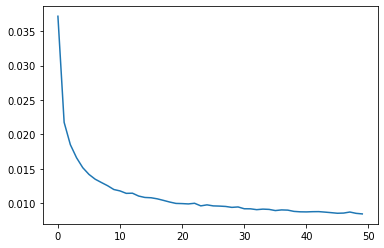

In [163]:
plt.plot(history.history['loss'])

In [0]:
real_stock_price = Y_test

In [165]:
real_stock_price

array([[0.06351146],
       [0.05069824],
       [0.05923385],
       ...,
       [0.94639214],
       [0.96387517],
       [0.95149591]])

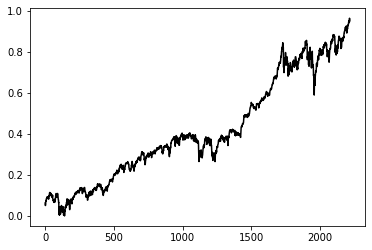

In [166]:
plt.plot(real_stock_price, color = 'black', label = 'DOW Stock Price')

In [0]:
predicted_stock_price = model.predict(X_test)

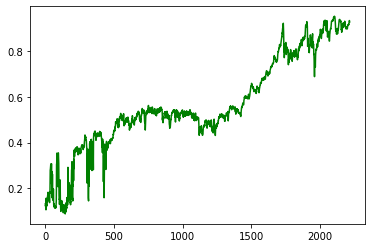

In [168]:
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted DOW Stock Price')

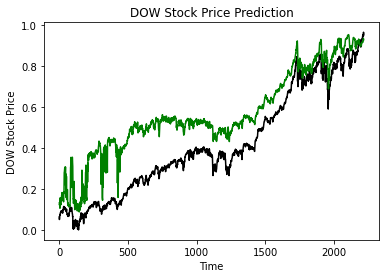

In [169]:
plt.plot(real_stock_price, color = 'black', label = 'DOW Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted DOW Stock Price')
plt.title('DOW Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('DOW Stock Price')
plt.show()

In [0]:
def RNNmodel_predict(n):
    print("實際的道瓊指數是：", real_stock_price[n:n+10])
    print("神經網路RNN的預測是：", predicted_stock_price[n:n+10])
 
    

In [171]:
from ipywidgets import interact_manual
interact_manual(RNNmodel_predict, n=(0, 2216))

interactive(children=(IntSlider(value=1108, description='n', max=2216), Button(description='Run Interact', sty…

<function __main__.RNNmodel_predict>